# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data


The train, validation and test data are loaded from the respective pickle file. Each image has the shape 32x32x3. So, it is given by 3 channel image (R,G,B). 

In [1]:
# Load pickled data
import pickle
import numpy as np
import scipy.ndimage as scnd
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import cv2
# Open training and testing data

training_file = '../data/train.p'
validation_file= '../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

#initial shape of traffic sign image
print("Initial Image Shape: {}".format(X_train[0].shape))

Initial Image Shape: (32, 32, 3)


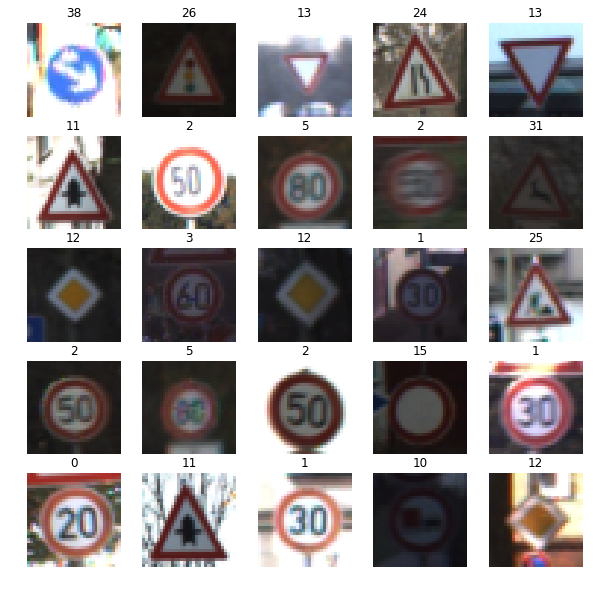

In [2]:
#Visualize a random image from the training data
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

# show image of 10 random data points
fig, axs = plt.subplots(5,5, figsize=(10, 10))
axs = axs.ravel()
for i in range(25):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])


By observing the above images, it can be noted that the images are 

- rotated from a ideal traffic sign image.
- transformed from a ideal traffic sign image.
- noisy image.
- blurred images.

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**



### Summary of the Data Set 

In [3]:
#Number of training examples
n_train = len(X_train)

#Number of validation examples
n_validation = len(X_valid)

#Number of testing examples.
n_test = len(X_test)

# shape of an traffic sign image
image_shape = X_train[0].shape

#unique classes/labels there are in the dataset.
n_classes = len(np.unique(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Distribution of the Classes 

It could be observed that there is imbalance of data in the training set. Imbalanced data sets are a special case for classification problem where the class distribution is not uniform among the classes. 


In [4]:
#find the distribution of classes within the training data
signs, counts = np.unique(y_train, return_counts=True)

for each_signs in range(0,len(signs)):
    print("Class : " + str(each_signs) + " Counts :" + str(counts[each_signs]))
    


Class : 0 Counts :180
Class : 1 Counts :1980
Class : 2 Counts :2010
Class : 3 Counts :1260
Class : 4 Counts :1770
Class : 5 Counts :1650
Class : 6 Counts :360
Class : 7 Counts :1290
Class : 8 Counts :1260
Class : 9 Counts :1320
Class : 10 Counts :1800
Class : 11 Counts :1170
Class : 12 Counts :1890
Class : 13 Counts :1920
Class : 14 Counts :690
Class : 15 Counts :540
Class : 16 Counts :360
Class : 17 Counts :990
Class : 18 Counts :1080
Class : 19 Counts :180
Class : 20 Counts :300
Class : 21 Counts :270
Class : 22 Counts :330
Class : 23 Counts :450
Class : 24 Counts :240
Class : 25 Counts :1350
Class : 26 Counts :540
Class : 27 Counts :210
Class : 28 Counts :480
Class : 29 Counts :240
Class : 30 Counts :390
Class : 31 Counts :690
Class : 32 Counts :210
Class : 33 Counts :599
Class : 34 Counts :360
Class : 35 Counts :1080
Class : 36 Counts :330
Class : 37 Counts :180
Class : 38 Counts :1860
Class : 39 Counts :270
Class : 40 Counts :300
Class : 41 Counts :210
Class : 42 Counts :210


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

### Normalizing images
By the paper of Yann LeCunn, it has been proposed that using 3 channel images did not optimize the accuracy. So, the images are normalized to single channel images.

In [5]:
#opencv function to change the rgb image into grayscale image
def list2Gray(pickle_list):
    gray_list = []
    for each_image in range(0,len(pickle_list)):
        gray_image = cv2.cvtColor(pickle_list[each_image], cv2.COLOR_RGB2GRAY)
        gray_image = gray_image.reshape(32,32,1)
        gray_list.append(gray_image)
    return gray_list
    
#making pixel value in range (0 - 1)
def normalize_gray(x):
    return x/np.float32(255)

gray_train = list2Gray(X_train)
gray_train_norm = normalize_gray(gray_train)

gray_valid = list2Gray(X_valid)
gray_valid_norm = normalize_gray(gray_valid)

gray_test = list2Gray(X_test)
gray_test_norm = normalize_gray(gray_test)



image_shape = gray_valid_norm[0].shape
print("Image data shape =", image_shape)

print("Training Dataset : ",gray_train_norm.shape)
print("Valid Dataset : ",gray_valid_norm.shape)
print("Test Dataset : ",gray_test_norm.shape)

Image data shape = (32, 32, 1)
Training Dataset :  (34799, 32, 32, 1)
Valid Dataset :  (4410, 32, 32, 1)
Test Dataset :  (12630, 32, 32, 1)


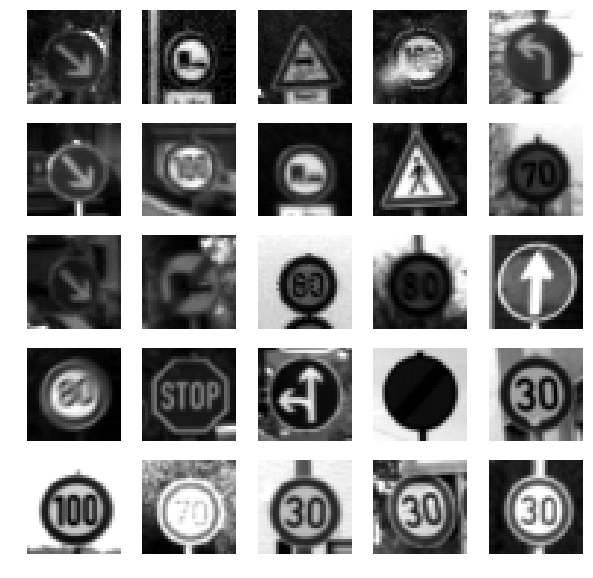

In [6]:
def visualize_gray(pickle_list):
    fig, axs = plt.subplots(5,5, figsize=(10, 10))
    axs = axs.ravel()
    for i in range(25):
        index = random.randint(0, len(pickle_list))
        image = pickle_list[index].reshape(32,32)
        axs[i].axis('off')
        axs[i].imshow(image, cmap='gray')

visualize_gray(gray_train_norm)

# Data augmentation

Initially the model was trained with the same data set given in the pickle file. Since, there is an imbalance of data distribution throughout the classes, the model started overfitting. This happens because the classes having more number of images will be a dominant class and influences the weights of the network drastically. So, any other classes (minority in count) will be misclassified. Due to this reason, we create images by using data augmentation method. This method generates data by manupulating existing data. Finally we make sure that all the classes have equally distributed images in it.

The strategies used to generate augumented images are :

- Translate image by tuned threshold
- Rotate image by tuned angle
- Blur image within tuned threshold
- Crop image by tuned threshold
- Sharpen image by tuned threshold

To include randomness, these methods are chosen randomly on random images present in a class.

In [7]:
generate_augumented_data = True

In [8]:

def data_augmentation(img):
    
    random_process = np.random.randint(0,4)

    if random_process == 0:

        x_transformation = np.random.uniform(-0.3 * img.shape[0], 0.3 * img.shape[0])
        y_transformation = np.random.uniform(-0.3 * img.shape[1], 0.3 * img.shape[1])
        transformatioin_matrix = np.float32([[1, 0, x_transformation], [0, 1, y_transformation]])
        
        augumented_img = cv2.warpAffine(img, transformatioin_matrix, (img.shape[0], img.shape[1]))

        
    elif random_process == 2:

        rotation_angle = np.random.uniform(-60, 60)
        center_point = (img.shape[0] / 2, img.shape[1] / 2)
        rotation_matrix = cv2.getRotationMatrix2D(center_point, rotation_angle, 1)

        augumented_img = cv2.warpAffine(img, rotation_matrix, (img.shape[0], img.shape[1]))
        
    elif random_process == 3:
        
        r_int = np.random.randint(0, 2)
        odd_size = 2 * r_int + 1
        
        augumented_img = cv2.GaussianBlur(img, (odd_size, odd_size), 0)
        
    elif random_process == 1:
        
        crop = np.random.randint(5,15)
        formed_pt1 = np.array([[5, 5], [20, 5], [5, 20]]).astype('float32')
        pt1 = 5 + crop * np.random.uniform() - crop / 2
        pt2 = 20 + crop * np.random.uniform() - crop / 2
        formed_pt2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])
        crop_matrix = cv2.getAffineTransform(formed_pt1, formed_pt2)
        
        augumented_img = cv2.warpAffine(img, crop_matrix, (img.shape[0], img.shape[1]))
        
        
    elif random_process == 4:
        
        sharpen = cv2.GaussianBlur(img, (5,5), 50.0)
        
        augumented_img = cv2.addWeighted(img, 2, sharpen, -1, 0)

    return augumented_img.reshape(32,32,1)

By setting the min class images theshold, we make sure that the number of images in each classes will be the same. This should be applied only on training images and so this runs only with training images. 

In [9]:

if (generate_augumented_data == True):
    X_train_norm = gray_train_norm
    min_class_images = 4500
    
    for i in range( 0, n_classes ):
        if( counts[i] < min_class_images ): 
            n_train += min_class_images - counts[i]

    # Generated data
    n_data_agumented = n_train - len(X_train)
    print("Data to be generated : " + str(n_data_agumented))

    #initialize with zeros
    X_train_augmented = \
        np.zeros( (n_data_agumented,image_shape[0],image_shape[1],image_shape[2]) )
    y_train_augmented = \
        np.zeros( n_data_agumented, dtype=int )


    augmented_example = 0
    for i in range( 0, n_classes ):
        if( counts[i] < min_class_images ):
            
                class_images = X_train_norm[y_train == i]
                for j in range( 0, min_class_images -  counts[i]):
                    
                    # Add a new image by picking a random existing example and augmenting it.
                    index = random.randint(0,counts[i]-1)
                    
                    X_train_augmented[augmented_example] = \
                        data_augmentation( class_images[index] )
                    
                    y_train_augmented[augmented_example] = i
                    augmented_example += 1

    # Create full training data by concatenating original and augmented data            
    X_train = np.concatenate((X_train_norm,X_train_augmented))
    y_train = np.concatenate((y_train,y_train_augmented))

    print( "Updated training data size : " + str(len(X_train)))

Data to be generated : 158701
Updated training data size : 193500


### Updated distribution of classes

In [10]:
signs, counts = np.unique(y_train, return_counts=True)

for each_signs in range(0,len(signs)):
    print("Class : " + str(each_signs) + " Counts :" + str(counts[each_signs]))

Class : 0 Counts :4500
Class : 1 Counts :4500
Class : 2 Counts :4500
Class : 3 Counts :4500
Class : 4 Counts :4500
Class : 5 Counts :4500
Class : 6 Counts :4500
Class : 7 Counts :4500
Class : 8 Counts :4500
Class : 9 Counts :4500
Class : 10 Counts :4500
Class : 11 Counts :4500
Class : 12 Counts :4500
Class : 13 Counts :4500
Class : 14 Counts :4500
Class : 15 Counts :4500
Class : 16 Counts :4500
Class : 17 Counts :4500
Class : 18 Counts :4500
Class : 19 Counts :4500
Class : 20 Counts :4500
Class : 21 Counts :4500
Class : 22 Counts :4500
Class : 23 Counts :4500
Class : 24 Counts :4500
Class : 25 Counts :4500
Class : 26 Counts :4500
Class : 27 Counts :4500
Class : 28 Counts :4500
Class : 29 Counts :4500
Class : 30 Counts :4500
Class : 31 Counts :4500
Class : 32 Counts :4500
Class : 33 Counts :4500
Class : 34 Counts :4500
Class : 35 Counts :4500
Class : 36 Counts :4500
Class : 37 Counts :4500
Class : 38 Counts :4500
Class : 39 Counts :4500
Class : 40 Counts :4500
Class : 41 Counts :4500
Cl

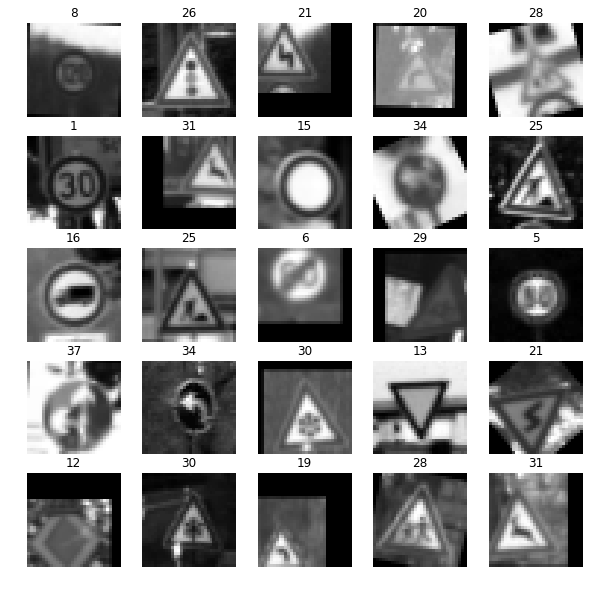

In [11]:
# show image of 10 random data points
fig, axs = plt.subplots(5,5, figsize=(10, 10))
axs = axs.ravel()
for i in range(25):
    index = random.randint(0, len(X_train))
    image = X_train[index].reshape(32,32)
    axs[i].axis('off')
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(y_train[index])

In [12]:
#randomize order of images
X_train, y_train = shuffle(X_train, y_train)
X_train.shape

(193500, 32, 32, 1)

In [13]:
X_valid = gray_valid_norm
X_valid.shape

(4410, 32, 32, 1)

Define convolution hyper parameters. These values are obtained after fine tuning by various combinations of values.

In [14]:
EPOCHS = 150
BATCH_SIZE = 128
rate = 0.001

### Model Architecture

Lenet Architecture modified to fit the training data of traffic sign dataset.

<img src="lenet.png">

This architecture is given by Yann LeCunns paper for CNN used for MNIST dataset classification.

In [15]:

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W= tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean=mu, stddev=sigma))
    conv1_b= tf.Variable(tf.zeros(6))
    conv1= tf.nn.conv2d(x,conv1_W,strides=[1,1,1,1],padding='VALID',use_cudnn_on_gpu=True) + conv1_b

    # Activation.
    conv1= tf.nn.relu(conv1)

    # Layer 2: Convolutional. Input = 28x28x6. Output = 14x14x10.
    conv3_W= tf.Variable(tf.truncated_normal(shape=(5,5,6,10), mean=mu, stddev=sigma))
    conv3_b= tf.Variable(tf.zeros(10))
    conv3= tf.nn.conv2d(conv1,conv3_W,strides=[1,2,2,1],padding='VALID',use_cudnn_on_gpu=True) + conv3_b

    # Activation.
    conv3= tf.nn.relu(conv3)

    # Layer 3: Convolutional. Input = 14x14x10. Output = 8x8x16.
    conv2_W= tf.Variable(tf.truncated_normal(shape=(5,5,10,16),mean=mu,stddev=sigma))
    conv2_b=tf.Variable(tf.zeros(16))
    conv2= tf.nn.conv2d(conv3,conv2_W,strides=[1,1,1,1],padding='VALID',use_cudnn_on_gpu=True) + conv2_b
    
    # Activation.
    conv2= tf.nn.relu(conv2)

    # Pooling. Input = 8x8x16. Output = 4x4x16.
    conv2= tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

    # Flatten. Input = 4x4x16. Output = 256.
    f= flatten(conv2)

    # Layer 4: Fully Connected. Input = 256. Output = 120.
    fc1_W= tf.Variable(tf.truncated_normal(shape=(int(np.shape(f)[1]),120),mean=mu,stddev=sigma))
    fc1_b= tf.Variable(tf.zeros(shape=120))
    fc1= tf.matmul(f,fc1_W) + fc1_b
    
    # Activation.
    fc1= tf.nn.relu(fc1)
    
    # Introduce Dropout after first fully connected layer
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 5: Fully Connected. Input = 120. Output = 100.
    fc2_W= tf.Variable(tf.truncated_normal(shape=(120,100),mean=mu,stddev=sigma))
    fc2_b= tf.Variable(tf.zeros(100))
    fc2= tf.matmul(fc1,fc2_W) + fc2_b
    
    # Activation.
    fc2= tf.nn.relu(fc2)
    
    # Layer 6: Fully Connected. Input = 100. Output = 84.
    fc4_W= tf.Variable(tf.truncated_normal(shape=(100,84),mean=mu,stddev=sigma))
    fc4_b= tf.Variable(tf.zeros(84))
    fc4= tf.matmul(fc2,fc4_W) + fc4_b
    
    # Activation.
    fc4= tf.nn.relu(fc4)
    
    # Layer 7: Fully Connected. Input = 84. Output = 43.
    fc3_W= tf.Variable(tf.truncated_normal(shape=(84,43),mean=mu,stddev=sigma))
    fc3_b= tf.Variable(tf.zeros(43))
    fc3= tf.matmul(fc4,fc3_W) + fc3_b
    logits=fc3
        
    return logits

In [16]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43) 
keep_prob = tf.placeholder(tf.float32) 

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [17]:
#defining the network and loss function
logits = LeNet(x) 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Evaluate function is defined for prediction of the result. Note that the drop out layer will have probability set to 1. (We dont need dropout layer deactivating tensors while predicting results)

In [18]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={
            x: batch_x, 
            y: batch_y,
            keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Training of CNN
Defining the pipeline to start training the CNN model. Note that the dropout layer probability is set to 0.5

In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training with {} examples...".format(num_examples))
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={
                x: batch_x, 
                y: batch_y,
                keep_prob: 0.5})

        print("EPOCH {} ...".format(i+1))
        validation_accuracy = evaluate(X_valid, y_valid)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print('\n')
        
    saver.save(sess, './model_save_sharp')
    print("Model saved")

Training with 193500 examples...

EPOCH 1 ...
Validation Accuracy = 0.862


EPOCH 2 ...
Validation Accuracy = 0.915


EPOCH 3 ...
Validation Accuracy = 0.922


EPOCH 4 ...
Validation Accuracy = 0.944


EPOCH 5 ...
Validation Accuracy = 0.942


EPOCH 6 ...
Validation Accuracy = 0.942


EPOCH 7 ...
Validation Accuracy = 0.947


EPOCH 8 ...
Validation Accuracy = 0.954


EPOCH 9 ...
Validation Accuracy = 0.954


EPOCH 10 ...
Validation Accuracy = 0.950


EPOCH 11 ...
Validation Accuracy = 0.957


EPOCH 12 ...
Validation Accuracy = 0.956


EPOCH 13 ...
Validation Accuracy = 0.963


EPOCH 14 ...
Validation Accuracy = 0.961


EPOCH 15 ...
Validation Accuracy = 0.954


EPOCH 16 ...
Validation Accuracy = 0.965


EPOCH 17 ...
Validation Accuracy = 0.952


EPOCH 18 ...
Validation Accuracy = 0.960


EPOCH 19 ...
Validation Accuracy = 0.956


EPOCH 20 ...
Validation Accuracy = 0.962


EPOCH 21 ...
Validation Accuracy = 0.960


EPOCH 22 ...
Validation Accuracy = 0.956


EPOCH 23 ...
Validation Accur

### Test Images

Test data is normalized and then evaluated in the model.

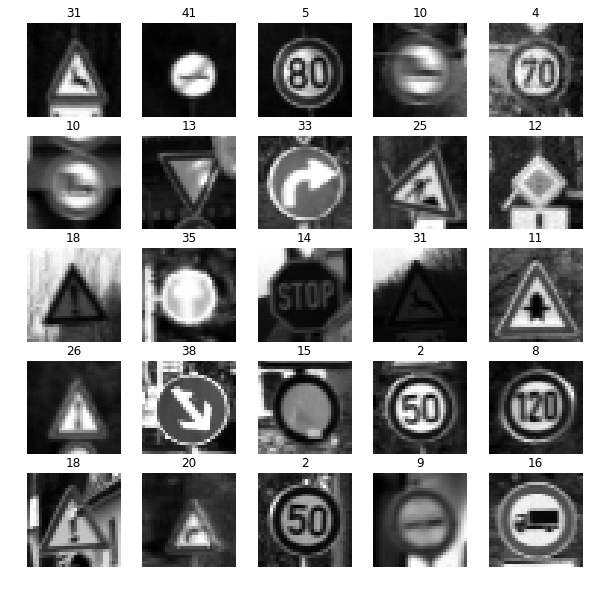

In [19]:
X_test = gray_test_norm

# show image of 10 random data points
fig, axs = plt.subplots(5,5, figsize=(10, 10))
axs = axs.ravel()
for i in range(25):
    index = random.randint(0, len(X_test))
    image = X_test[index].reshape(32,32)
    axs[i].axis('off')
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(y_test[index])

### Evaluation of test data 

In [20]:
with tf.Session() as sess:
    saver.restore(sess, './model_save_sharp')
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./model_save_sharp
Test Accuracy = 0.955


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

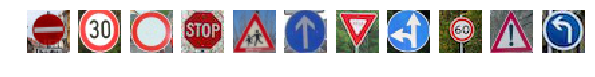

In [27]:
import os
import matplotlib.image as mpimg
unseen_pics = os.listdir("unseen_web_images/")
unseen_test_data = []
for i in unseen_pics:
    if not(i.endswith("checkpoints")):
        i = 'unseen_web_images/' + i
        image = mpimg.imread(i)
        unseen_test_data.append(image)

unseen_test_data = np.array(unseen_test_data)

fig, axs = plt.subplots(1,11, figsize=(10, 10))
axs = axs.ravel()
for i in range(11):
    image = unseen_test_data[i].reshape(32,32,3)
    axs[i].axis('off')
    axs[i].imshow(image, cmap='gray')


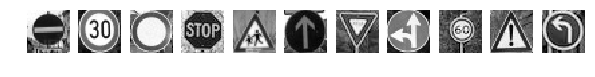

In [29]:
gray_web_test = list2Gray(unseen_test_data)
gray_web_test_norm = normalize_gray(gray_web_test)

fig, axs = plt.subplots(1,11, figsize=(10, 10))
axs = axs.ravel()
for i in range(11):
    image = gray_web_test_norm[i].reshape(32,32)
    axs[i].axis('off')
    axs[i].imshow(image, cmap='gray')

In [30]:
with tf.Session() as sess:
    saver.restore(sess, './model_save_sharp')
    predicted_probabilites = sess.run(logits, feed_dict={x: gray_web_test_norm, keep_prob : 1.0})

for i in range (0, len(gray_web_test_norm)):
    print(np.argmax(predicted_probabilites[i]))

INFO:tensorflow:Restoring parameters from ./model_save_sharp
17
1
15
14
28
35
13
37
5
18
34


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [32]:
with tf.Session() as sess:
    saver.restore(sess, './model_save_sharp')
    predicted_probabilites = sess.run(logits, feed_dict={x: gray_web_test_norm, keep_prob : 1.0})
    softmax_result = tf.nn.softmax(predicted_probabilites)
    k_max_probability = sess.run(tf.nn.top_k(softmax_result, k=5))


INFO:tensorflow:Restoring parameters from ./model_save_sharp


In [33]:
import csv
with open('signnames.csv', 'r') as f:
  reader = csv.reader(f)
  sign_list = list(reader)


for each_image in range(0,11):
    for each_predicted_probability in range(0, 5):
        print(sign_list[k_max_probability[1][each_image][each_predicted_probability] + 1][1] + " = " + str(k_max_probability[0][each_image][each_predicted_probability]*100)+ "%")
    print()

No entry = 100.0%
Vehicles over 3.5 metric tons prohibited = 8.16541387456e-12%
Go straight or left = 4.00861899826e-13%
Keep right = 1.71183706926e-13%
Turn left ahead = 1.3581114518e-13%

Speed limit (30km/h) = 95.9677278996%
Speed limit (50km/h) = 3.49726639688%
Speed limit (70km/h) = 0.27938215062%
Speed limit (20km/h) = 0.179711391684%
Speed limit (80km/h) = 0.0434404588304%

No vehicles = 99.9654054642%
Speed limit (30km/h) = 0.0109753447759%
Speed limit (70km/h) = 0.00632794763078%
Yield = 0.00533499660378%
Speed limit (50km/h) = 0.00424968347943%

Stop = 99.832957983%
Speed limit (50km/h) = 0.0761548464652%
Priority road = 0.025802970049%
Keep right = 0.0215849853703%
Speed limit (30km/h) = 0.0179546317668%

Children crossing = 99.9964356422%
Road work = 0.00124022271848%
Right-of-way at the next intersection = 0.000802032718639%
Beware of ice/snow = 0.000777662262408%
Pedestrians = 0.000555409860681%

Ahead only = 99.9994158745%
Go straight or right = 0.000364334641745%
Turn l

Out of 11 completely unseen images, the model could predict 10 correctly (accuracy = 91%). This shows that the model is robust enough and with further fine tuning of hyper parameters, the accuracy could be further more improved.